In [ ]:
!python --version

Python 3.10.6


In [ ]:
!nvidia-smi

Fri Jul 21 09:11:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:00<00:00, 101750539.85it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6263021.48it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 67406255.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4605861.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64)

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 1, 28, 28])

In [ ]:
len(train_set)

60000

9


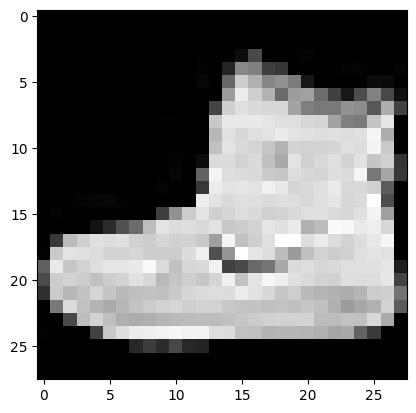

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

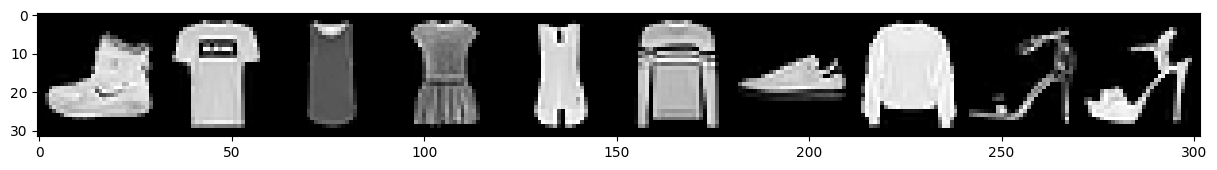

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
error = nn.CrossEntropyLoss()
learning_rate=0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
num_epochs = 100
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available


        # No need to wrap tensors with Variable in PyTorch versions above 0.4.0
        # train = Variable(images.view(64, 1, 28, 28))
        # labels = Variable(labels)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

        # Testing the model
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
            all_predictions = []
            all_labels = []

            with torch.no_grad():
                for images, labels in test_loader:


                    test = images.view(images.size(0), -1)

                    outputs = model(test)

                    predictions = torch.max(outputs, 1)[1]
                    all_predictions.extend(predictions.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    correct += (predictions == labels).sum().item()

                    total += labels.size(0)

            accuracy = correct * 100 / total
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)



        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.item(), accuracy))

Iteration: 500, Loss: 0.9629256129264832, Accuracy: 65.37%
Iteration: 1000, Loss: 1.138036847114563, Accuracy: 65.54%
Iteration: 1500, Loss: 0.853042721748352, Accuracy: 66.64%
Iteration: 2000, Loss: 1.0460795164108276, Accuracy: 66.44%
Iteration: 2500, Loss: 0.810360312461853, Accuracy: 67.58%
Iteration: 3000, Loss: 1.0503689050674438, Accuracy: 68.17%
Iteration: 3500, Loss: 0.8534530997276306, Accuracy: 69.02%
Iteration: 4000, Loss: 0.5766898989677429, Accuracy: 69.21%
Iteration: 4500, Loss: 0.6946374773979187, Accuracy: 70.02%
Iteration: 5000, Loss: 0.7837918400764465, Accuracy: 70.79%
Iteration: 5500, Loss: 0.5589607357978821, Accuracy: 71.35%
Iteration: 6000, Loss: 0.7080026865005493, Accuracy: 72.15%
Iteration: 6500, Loss: 0.6122647523880005, Accuracy: 72.48%
Iteration: 7000, Loss: 0.7374030351638794, Accuracy: 73.49%
Iteration: 7500, Loss: 0.6872362494468689, Accuracy: 73.76%
Iteration: 8000, Loss: 0.7017312049865723, Accuracy: 74.19%
Iteration: 8500, Loss: 0.5899339914321899, A

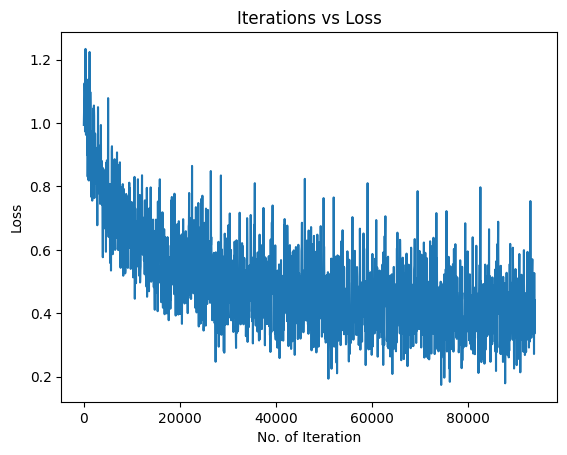

In [35]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

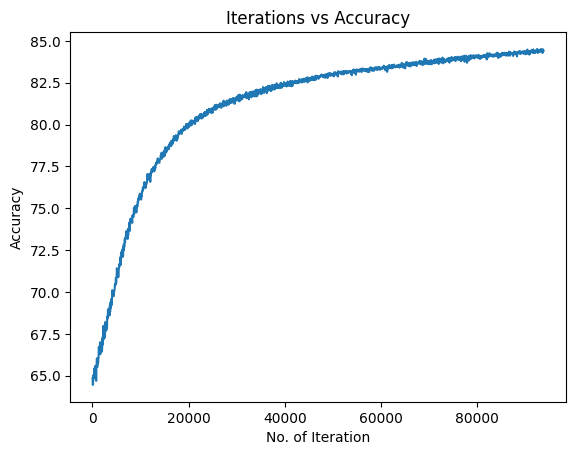

In [36]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [37]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:

        test = images
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):  # Use len(labels) to iterate over the actual number of items in the batch
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 82.20%
Accuracy of Trouser: 95.60%
Accuracy of Pullover: 73.30%
Accuracy of Dress: 86.40%
Accuracy of Coat: 77.30%
Accuracy of Sandal: 92.60%
Accuracy of Shirt: 56.20%
Accuracy of Sneaker: 91.20%
Accuracy of Bag: 94.00%
Accuracy of Ankle Boot: 95.20%


In [38]:
import sklearn.metrics as metrics

confusion_matrix(all_labels, all_predictions)
print("Classification report for Neural nerwork:\n%s\n"
      % (metrics.classification_report(all_labels, all_predictions)))

Classification report for Neural nerwork:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.74      0.73      0.74      1000
           3       0.83      0.86      0.85      1000
           4       0.72      0.77      0.75      1000
           5       0.94      0.93      0.94      1000
           6       0.64      0.56      0.60      1000
           7       0.92      0.91      0.91      1000
           8       0.94      0.94      0.94      1000
           9       0.92      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000




Confusion Matrix:
[[822   2  13  50   6   2  91   0  14   0]
 [  5 956   6  27   4   0   1   0   1   0]
 [ 21   4 733   9 144   1  80   0   8   0]
 [ 33  11  13 864  36   0  39   0   4   0]
 [  0   1  94  38 773   1  86   0   7   0]
 [  0   0   0   1   0 926   0  43   2  28]
 [149   2 114  42 104   1 562   0  26   0]
 [  0   0   0   0   0  34   0 912   0  54]
 [  3   1  15  12   3   3  18   5 940   0]
 [  0   0   0   0   0  12   0  35   1 952]]


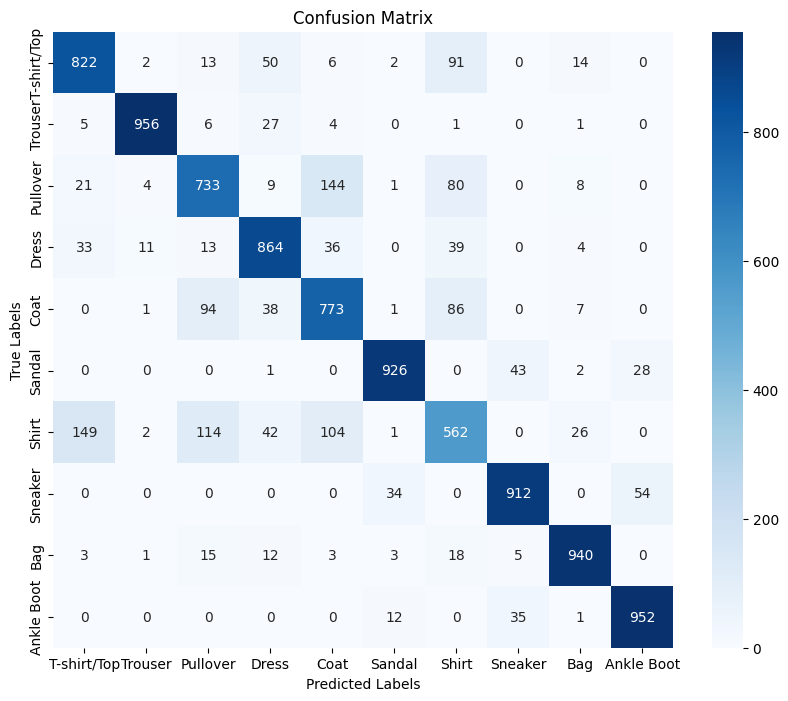

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have `predictions_l` and `labels_l` containing the predicted labels and ground truth labels, respectively

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Alternatively, you can visualize the confusion matrix using a heatmap (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of class names
classes = ["T-shirt/Top", "Trouser", "Pullover" , "Dress" , "Coat" , "Sandal" , "Shirt" , "Sneaker" , "Bag" , "Ankle Boot"]  # Replace with your actual class names

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()







